In [1]:
import deepxde as dde
import numpy as np
from deepxde.backend import tf
import matplotlib.pyplot as plt

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# Define the Reynolds number for the analytical solution
# Re = 1,50,100,300
Re_fixed = 100

# Define the spatial and temporal grid
N_t = 100  # Number of time points
N_x = 256  # Number of spatial points
t = np.linspace(0, 0.99, N_t)  # Time grid
x = np.linspace(-1, 1, N_x)    # Spatial grid

# Define the analytical solution for the 1D Burgers equation
def analytical_solution(x, t, Re_fixed):
    to = np.exp(Re_fixed / 8)  # Parameter in the equation
    u = x / (t + 1) / (1 + np.sqrt((t + 1) / to) * np.exp(Re_fixed * x**2 / (4 * (t + 1))))
    return u

# Compute the solution
usol = np.array([[analytical_solution(xi, ti, Re_fixed) for xi in x] for ti in t])

# Save the data to a .npz file
np.savez("dataset/Burgers.npz", t=t, x=x, usol=usol)


### Part (a): Forward Problem

Training for fixed Re = 100
Compiling model...
Building feed-forward neural network...
'build' took 0.069556 s


'compile' took 0.594932 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [3.55e-01, 1.10e+00, 1.75e+00]    [3.55e-01, 1.10e+00, 1.75e+00]    []  
1000      [4.41e-02, 5.60e-03, 6.62e-02]    [4.41e-02, 5.60e-03, 6.62e-02]    []  
2000      [3.39e-02, 6.96e-04, 4.00e-02]    [3.39e-02, 6.96e-04, 4.00e-02]    []  
3000      [5.20e-03, 7.44e-05, 2.83e-03]    [5.20e-03, 7.44e-05, 2.83e-03]    []  
4000      [2.29e-03, 1.57e-05, 6.54e-04]    [2.29e-03, 1.57e-05, 6.54e-04]    []  
5000      [1.34e-03, 1.08e-05, 2.15e-04]    [1.34e-03, 1.08e-05, 2.15e-04]    []  
6000      [2.49e-03, 4.90e-05, 1.34e-04]    [2.49e-03, 4.90e-05, 1.34e-04]    []  
7000      [5.84e-04, 3.94e-06, 3.98e-05]    [5.84e-04, 3.94e-06, 3.98e-05]    []  
8000      [5.24e-04, 7.86e-06, 2.69e-05]    [5.24e-04, 7.86e-06, 2.69e-05]    []  
9000

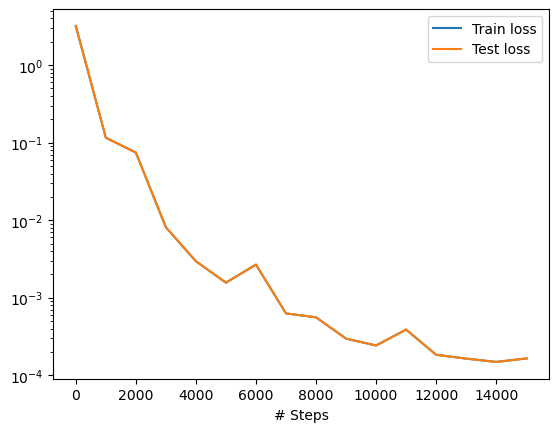

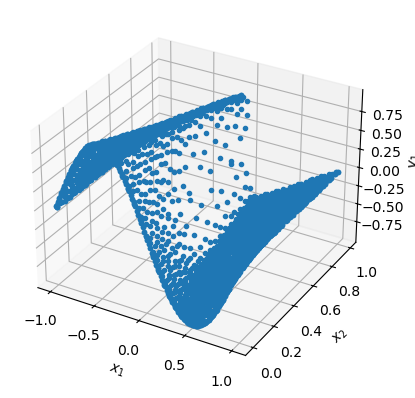

Fixed Re = 100, Mean residual: 0.007145358715206385
Fixed Re = 100, L2 relative error: 3.838923674089765


In [3]:
# Define fixed Reynolds number
# Re = 1,50,100,300
Re_fixed = 100

# Generate analytical test data
def gen_testdata():
    data = np.load("dataset/Burgers.npz")  # Ensure the file is present in the correct location
    t, x, exact = data["t"], data["x"], data["usol"].T
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y

# Define the PDE
def pde(x, y, Re):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t + y * dy_x - 1 / Re * dy_xx # Re=Re_fixed/100

# Define the domain and conditions
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 0.99)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)
bc = dde.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.IC(
    geomtime, lambda x: -np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial
)

# Solve the forward problem for fixed Re
print(f"Training for fixed Re = {Re_fixed}")

# Define dataset for fixed Re
data_fixed = dde.data.TimePDE(
    geomtime, lambda x, y: pde(x, y, Re_fixed), [bc, ic], num_domain=2540, num_boundary=80, num_initial=160
)

# Define the neural network
net_fixed = dde.maps.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
model_fixed = dde.Model(data_fixed, net_fixed)
model_fixed.compile("adam", lr=1e-3)

# Train the model
model_fixed.train(epochs=15000)
model_fixed.compile("L-BFGS")
losshistory_fixed, train_state_fixed = model_fixed.train()

# Save results
dde.saveplot(losshistory_fixed, train_state_fixed, issave=True, isplot=True)

# Test the model
X_fixed, y_true_fixed = gen_testdata()
y_pred_fixed = model_fixed.predict(X_fixed)
f_fixed = model_fixed.predict(X_fixed, operator=lambda x, y: pde(x, y, Re_fixed))

# Print errors for fixed Re
print(f"Fixed Re = {Re_fixed}, Mean residual: {np.mean(np.absolute(f_fixed))}")
print(f"Fixed Re = {Re_fixed}, L2 relative error: {dde.metrics.l2_relative_error(y_true_fixed, y_pred_fixed)}")
np.savetxt(f"test_fixed_Re_{Re_fixed}.dat", np.hstack((X_fixed, y_true_fixed, y_pred_fixed)))


### Part (b): Combined Inverse-Forward Problem

Training for combined inverse-forward problem
Compiling model...
Building feed-forward neural network...
'build' took 0.068187 s

'compile' took 0.515656 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [3.57e-01, 1.14e+00, 1.75e+00]    [3.57e-01, 1.14e+00, 1.75e+00]    []  
1000      [4.72e-02, 8.49e-03, 7.51e-02]    [4.72e-02, 8.49e-03, 7.51e-02]    []  
2000      [3.45e-02, 1.04e-03, 3.97e-02]    [3.45e-02, 1.04e-03, 3.97e-02]    []  
3000      [6.29e-03, 1.39e-04, 3.56e-03]    [6.29e-03, 1.39e-04, 3.56e-03]    []  
4000      [3.51e-03, 2.62e-05, 1.14e-03]    [3.51e-03, 2.62e-05, 1.14e-03]    []  
5000      [2.08e-03, 2.07e-05, 4.77e-04]    [2.08e-03, 2.07e-05, 4.77e-04]    []  
6000      [1.36e-03, 1.63e-05, 2.81e-04]    [1.36e-03, 1.63e-05, 2.81e-04]    []  
7000      [9.90e-04, 1.41e-05, 1.92e-04]    [9.90e-04, 1.41e-05, 1.92e-04]    []  
8000      [6.50e-04, 5.41e-06, 1.15e-04]    [6.50e-04, 5.41e-06, 1.15e

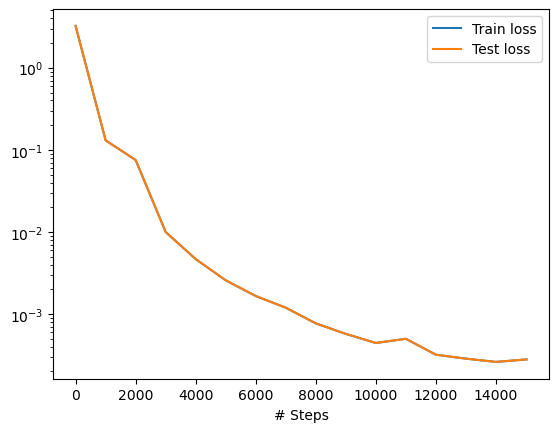

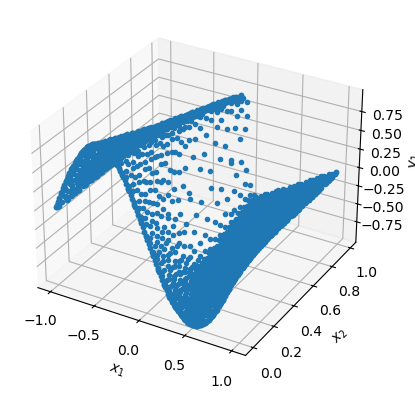

Mean residual for trainable Re: 0.010253123
L2 relative error for trainable Re: 3.827779358464919

Learned Reynolds number: 100.0


In [4]:
# Define Reynolds number as a trainable variable
Re_trainable = tf.Variable(Re_fixed, trainable=True, dtype=tf.float32)

# Generate analytical test data
def gen_testdata():
    data = np.load("dataset/Burgers.npz")  # Ensure the file is present in the correct location
    t, x, exact = data["t"], data["x"], data["usol"].T
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y

# Define the PDE
def pde_trainable(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t + y * dy_x - 1 / Re_trainable * dy_xx # Re=Re_fixed/100

# Define the domain and conditions
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 0.99)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)
bc = dde.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.IC(
    geomtime, lambda x: -np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial
)

# Solve the combined inverse-forward problem
print("Training for combined inverse-forward problem")

# Define dataset for trainable Re
data_trainable = dde.data.TimePDE(
    geomtime, pde_trainable, [bc, ic], num_domain=2540, num_boundary=80, num_initial=160
)
net_trainable = dde.maps.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
model_trainable = dde.Model(data_trainable, net_trainable)
model_trainable.compile("adam", lr=1e-3)

# Train the model
model_trainable.train(epochs=15000)
model_trainable.compile("L-BFGS")
losshistory_trainable, train_state_trainable = model_trainable.train()

# Save results
dde.saveplot(losshistory_trainable, train_state_trainable, issave=True, isplot=True)

# Test the model
X_trainable, y_true_trainable = gen_testdata()
y_pred_trainable = model_trainable.predict(X_trainable)
f_trainable = model_trainable.predict(X_trainable, operator=pde_trainable)

# Print errors
print("Mean residual for trainable Re:", np.mean(np.absolute(f_trainable)))
print("L2 relative error for trainable Re:", dde.metrics.l2_relative_error(y_true_trainable, y_pred_trainable))

# Use a TensorFlow session to evaluate Re_trainable
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    learned_Re = sess.run(Re_trainable)

print("Learned Reynolds number:", learned_Re)

# Save test results
np.savetxt(f"test_trainable_Re_{learned_Re:.1f}.dat", np.hstack((X_trainable, y_true_trainable, y_pred_trainable)))
